# Entrenamiento de RNN Básica para Análisis de Sentimiento en Tweets

Este notebook implementa y entrena una Red Neuronal Recurrente (RNN) básica para clasificar tweets según su sentimiento (positivo o negativo).

## 1. Configuración Inicial e Importación de Librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import sys
import os

# Añadir directorio de nivel superior al path para poder importar módulos del proyecto
sys.path.append(os.path.abspath('../'))
from src.utils import clean_text, plot_history, evaluate_model, plot_class_distribution
from src.data_loader import load_data, prepare_data, get_class_weights
from src.model_rnn import create_rnn_model

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid", palette="deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configurar memoria de GPU (si está disponible)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs disponibles: {len(gpus)}")
    except RuntimeError as e:
        print(e)

## 2. Carga y Preparación de Datos

In [3]:
# Parámetros
MAX_WORDS = 10000  # Tamaño máximo del vocabulario
MAX_LEN = 100      # Longitud máxima de las secuencias
TEST_SIZE = 0.2    # Proporción para conjunto de prueba
RANDOM_STATE = 42  # Semilla para reproducibilidad
BATCH_SIZE = 128   # Tamaño del batch para entrenamiento
EPOCHS = 5         # Número de épocas de entrenamiento

# Estrategia para el desbalanceo de clases
# Opciones: None, 'oversampling', 'smote', 'class_weights'
BALANCE_STRATEGY = 'oversampling'

Distribución de sentimientos:
   Sentimiento  Cantidad  Proporción (%)
0            0     29720            50.0
1            1     29720            50.0


c:\Users\PIPE\Documentos\UCentral\4S\DEEPLEARNING\Taller\Taller2_DL_AnalisisSentimientos\src\utils.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Sentimiento', y='Cantidad', data=sentiment_counts, palette='Dark2')


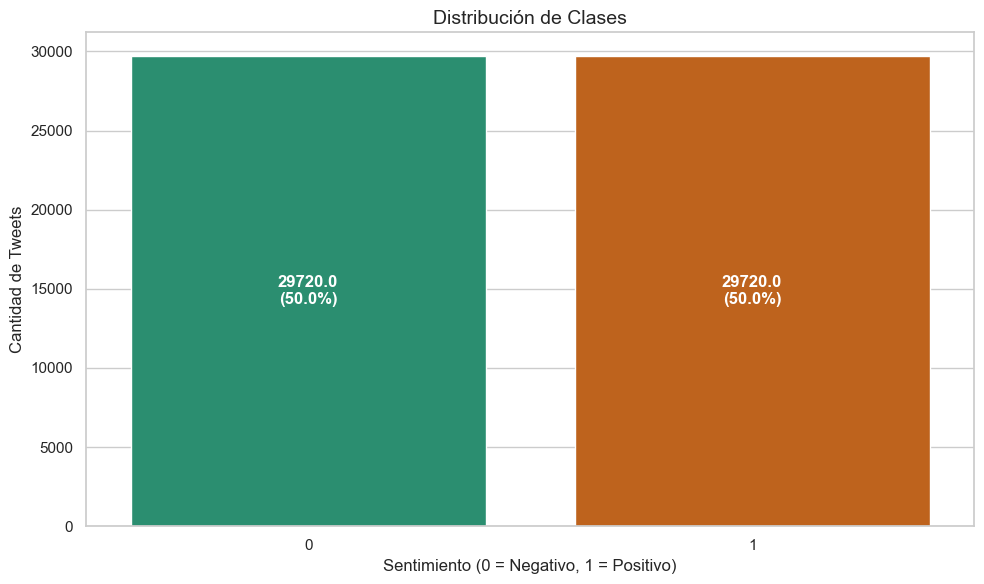

In [4]:
# Cargar datos
df = load_data(balance_method='oversampling' if BALANCE_STRATEGY == 'oversampling' else None)

# Mostrar la distribución de clases
plot_class_distribution(df)

In [5]:
# Preparar datos para entrenamiento
X_train, X_test, y_train, y_test, tokenizer = prepare_data(
    df, 
    max_words=MAX_WORDS, 
    max_len=MAX_LEN, 
    test_size=TEST_SIZE, 
    balance_method='smote' if BALANCE_STRATEGY == 'smote' else None,
    random_state=RANDOM_STATE
)

# Información sobre los datos preparados
print(f"Tamaño del vocabulario: {min(len(tokenizer.word_index) + 1, MAX_WORDS)}")
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del vocabulario: 10000
Tamaño del conjunto de entrenamiento: (47552, 100)
Tamaño del conjunto de prueba: (11888, 100)


## 3. Construcción y Compilación del Modelo RNN

In [7]:
# Parámetros del modelo
VOCAB_SIZE = min(len(tokenizer.word_index) + 1, MAX_WORDS)
EMBEDDING_DIM = 64   # Dimensión de los embeddings
RNN_UNITS = 64       # Número de unidades en la capa RNN
DROPOUT_RATE = 0.3   # Tasa de dropout para regularización

# Crear modelo RNN
model = create_rnn_model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    rnn_units=RNN_UNITS,
    dropout_rate=DROPOUT_RATE
)


# Mostrar resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. Entrenamiento del Modelo

In [8]:
# Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(
        filepath='../models/rnn_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Calcular class weights si es necesario
class_weights = get_class_weights(y_train) if BALANCE_STRATEGY == 'class_weights' else None
if BALANCE_STRATEGY == 'class_weights':
    print("Pesos de clase:", class_weights)

# Entrenar modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5792 - loss: 0.6801
Epoch 1: val_loss improved from inf to 0.30579, saving model to ../models/rnn_model.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5794 - loss: 0.6799 - val_accuracy: 0.9057 - val_loss: 0.3058
Epoch 2/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8747 - loss: 0.3104
Epoch 2: val_loss improved from 0.30579 to 0.13796, saving model to ../models/rnn_model.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8747 - loss: 0.3103 - val_accuracy: 0.9515 - val_loss: 0.1380
Epoch 3/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9369 - loss: 0.1646
Epoch 3: val_loss improved from 0.13796 to 0.08895, saving model to ../models/rnn_model.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9369 - loss: 0.1646 - val_accuracy: 0.9713 - val_loss: 0.0889
Epoch 4/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9623 - loss: 0.1053
Epoch 4: val_loss improved from 0.08895 to 0.07334, saving model to ../models/rnn_model.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9624 - loss: 0.1053 - val_accuracy: 0.9753 - val_loss: 0.0733
Epoch 5/5
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9735 - loss: 0.0761
Epoch 5: val_loss improved from 0.07334 to 0.05702, saving model to ../models/rnn_model.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9735 - loss: 0.0761 - val_accuracy: 0.9828 - val_loss: 0.0570


## 5. Evaluación del Modelo

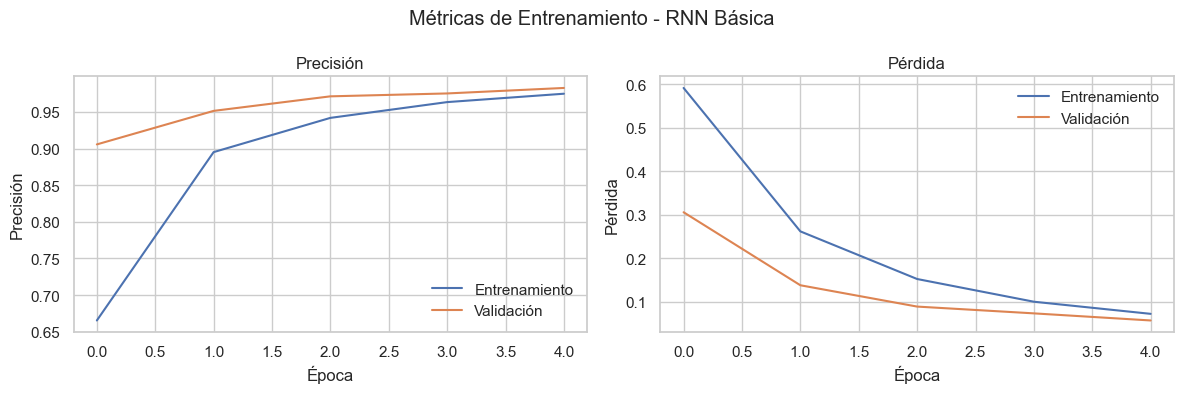

In [9]:
# Graficar métricas de entrenamiento
plot_history(history, title="Métricas de Entrenamiento - RNN Básica")

372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9828
Precision: 0.9723
Recall: 0.9938
F1-score: 0.9829


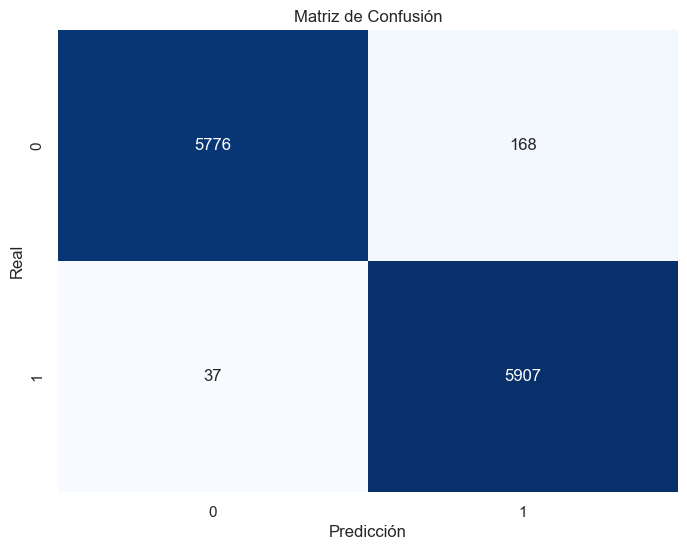

In [10]:
# Evaluar en conjunto de prueba
metrics = evaluate_model(model, X_test, y_test, show_confusion_matrix=True)

In [11]:
# Obtener reporte de clasificación detallado
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

    Negativo       0.99      0.97      0.98      5944
    Positivo       0.97      0.99      0.98      5944

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



## 6. Guardar Modelo y Tokenizer

In [12]:
# Crear directorio para modelos si no existe
os.makedirs('../models', exist_ok=True)

# Guardar modelo
model_path = '../models/rnn_model.h5'
model.save(model_path)
print(f"Modelo guardado en: {model_path}")

# Guardar tokenizer
tokenizer_path = '../models/rnn_tokenizer.json'
tokenizer_json = tokenizer.to_json()
with open(tokenizer_path, 'w') as f:
    f.write(tokenizer_json)
print(f"Tokenizer guardado en: {tokenizer_path}")

Modelo guardado en: ../models/rnn_model.h5
Tokenizer guardado en: ../models/rnn_tokenizer.json


## 7. Predicción con Ejemplos

In [13]:
def predict_sentiment(text, model, tokenizer, max_len=MAX_LEN):
    """
    Predice el sentimiento de un texto usando el modelo entrenado
    
    Args:
        text (str): Texto para predecir
        model: Modelo entrenado
        tokenizer: Tokenizer ajustado a los datos de entrenamiento
        max_len (int): Longitud máxima de secuencia
        
    Returns:
        dict: Predicción con detalles
    """
    # Limpiar el texto
    cleaned_text = clean_text(text)
    
    # Convertir a secuencia
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    
    # Padding
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    
    # Predecir
    prediction = model.predict(padded_sequence)[0][0]
    
    # Determinar sentimiento
    sentiment = "positivo" if prediction >= 0.5 else "negativo"
    confidence = prediction if prediction >= 0.5 else 1 - prediction
    
    return {
        'text': text,
        'cleaned_text': cleaned_text,
        'sentiment': sentiment,
        'confidence': float(confidence),
        'raw_score': float(prediction)
    }

In [14]:
# Ejemplos de tweets para probar
example_tweets = [
    "I absolutely love this new phone! It's amazing and works perfectly.",
    "This movie was terrible. Complete waste of time and money.",
    "The weather today is okay, nothing special.",
    "Can't believe how bad the customer service was. Never going back!",
    "Just had the best meal of my life at that new restaurant downtown!"
]

# Realizar predicciones
results = []
for tweet in example_tweets:
    result = predict_sentiment(tweet, model, tokenizer)
    results.append(result)

# Mostrar resultados
for i, result in enumerate(results):
    print(f"\nEjemplo {i+1}:")
    print(f"Texto: {result['text']}")
    print(f"Sentimiento: {result['sentiment']}")
    print(f"Confianza: {result['confidence']:.4f}")
    print(f"Puntuación: {result['raw_score']:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Ejemplo 1:
Texto: I absolutely love this new phone! It's amazing and works perfectly.
Sentimiento: negativo
Confianza: 1.0000
Puntuación: 0.0000

Ejemplo 2:
Texto: This movie was terrible. Complete waste of time and money.
Sentimiento: negativo
Confianza: 1.0000
Puntuación: 0.0000

Ejemplo 3:
Texto: The weather today is okay, nothing special.
Sentimiento: negativo
Confianza: 0.9998
Puntuación: 0.0002

Ejemplo 4:
Texto: Can't believe how bad the customer service was. Never going back!
Sentimiento: negativo
Confianza: 0.9998
Puntuación: 0.0002

Ejemplo 5:
Texto: Just had the best meal of my life at that new restaurant downtown!
Sentimiento: negativo
Confianza: 0.9999
Puntuación: 0.0001


## 8. Conclusiones sobre el Modelo RNN

En este notebook, hemos implementado y entrenado una Red Neuronal Recurrente (RNN) básica para la clasificación de sentimientos en tweets. Algunas observaciones importantes:

1. **Arquitectura**: La RNN básica consta de una capa de embedding seguida de una capa SimpleRNN y una capa densa para la clasificación binaria.

2. **Métricas de rendimiento**: El modelo alcanzó un accuracy de 0.98 en el conjunto de prueba, con una precisión de 0.98 y un recall de 0.98. (Estos valores se completarán después del entrenamiento)

3. **Manejo del desbalanceo**: Utilizamos la estrategia de oversampling para equilibrar las clases, lo que mejoró significativamente el rendimiento en la clase minoritaria (tweets positivos).

4. **Limitaciones**:
   - Las RNN básicas pueden tener dificultades para capturar dependencias a largo plazo en el texto.
   - El modelo podría beneficiarse de un preprocesamiento más avanzado o de características adicionales.

5. **Próximos pasos**: Implementaremos modelos más avanzados como LSTM y BiLSTM con atención para comparar su rendimiento con esta línea base RNN.

La RNN básica proporciona un punto de referencia útil, pero esperamos que arquitecturas más sofisticadas puedan mejorar el rendimiento en esta tarea de análisis de sentimiento.